In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
import conditionalconformal
from conditionalconformal import CondConf
import itertools
import math
from numpy import sin, cos, exp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2

/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-02 21:12:00.703973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 21:12:00.725598: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 21:12:01.012435: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 21:12:01.919305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

dimension_z = 100
dimension_x = 100
number_z = 30
# Generating 30 vectors, each with 100 dimensions
z_domain = np.random.normal(size=(number_z, dimension_z))

# Generating beta_1 and beta_2
beta_1 = np.random.uniform(-1, 1, dimension_x)
beta_2 = np.random.uniform(-1, 1, dimension_z)


In [3]:

def generate_function(beta_1, beta_2):

    def function_2(X, Z):
        # Calculate the epsilon (truncated normal distribution between -1 and 1)
        epsilon = np.random.uniform(-1, 1)

        # Calculate T
        #T = np.exp(2 * (np.sin(np.dot(beta_1.T, X)) + 3) + np.cos(np.dot(beta_2.T, Z))**2) + 1 + epsilon
        #T = np.exp(0.2*(np.dot(beta_1.T, X)) + np.cos(np.dot(beta_2.T, Z))) + 1 + epsilon
        T = exp(abs(np.dot(beta_1.T, X))/40)*(np.cos(np.dot(beta_2.T, Z))**2)  +1+ epsilon
        return T


    return function_2

function_2 = generate_function(beta_1, beta_2)


In [5]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,dimension_x:(dimension_x+dimension_z)])#len 500

    # Initialize the indicator matrix
    matrix = np.zeros((len(np.array(feature[:,1])), number_z))

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0, number_z):
            if  np.array_equal(value, z_domain[j]):
                matrix[i, j] = 1

    return matrix

In [6]:
# Function to combine X and Z into a single flattened array
flatten_features = lambda df: np.array([np.concatenate([x, z]) for x, z in zip(df['X'], df['Z'])])

In [6]:

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var_x = 8
def conformal_predict_z_0(alpha=0.1, m=100, Z_new=Z_new, N=1000, t=200):
    IR = []
    for j in range(t):
        data_points = []
        for _ in range(N):
            # Randomly select a vector from z_domain to be Z
            Z = z_domain[np.random.randint(z_domain.shape[0])]

            # Compute the mean of the square of Z
            mean_x = np.mean(Z**2)

            # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X = np.random.normal(mean_x, var_x, dimension_x)

            # Compute T_1 and T_2 using the generated functions
            T_1 = function_2(X, Z)
            #T_2 = function_2(X, Z)

            # Append the data point (X, Z, T_1, T_2) to the list
            data_points.append([X, Z, T_1])
        # Split the data into D_cali and D_train
        D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
        D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

        # Preparing data for regression
        X_train = flatten_features(D_train)
        # Extracting T_1 for D_train and D_cali
        Y_train = D_train['T_1'].values
        #构建神经网络模型
        model_nn = Sequential([
            InputLayer(input_shape=(X_train.shape[1],)),   
            Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # 使用LeakyReLU和L2正则化
            Dropout(0.3),
            Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
            Dense(1)               
        ])

        # 编译模型
        model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # 在 D_train 上训练模型
        history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
        
        score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())
        
        data_points_new = []
        for _ in range(m):
            # Compute the mean of the square of Z
            mean_x_new = np.mean(Z_new**2)
            # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X_new = np.random.normal(mean_x_new, var_x, dimension_x)
            # Compute T_1 and T_2 using the generated functions
            T_1_new = function_2(X_new, Z_new)
            #T_2_new = function_2(X_new, Z_new)

            # Append the data point (X, Z, T_1, T_2) to the list
            data_points_new.append([X_new, Z_new, T_1_new])

        # Split the data into D_cali and D_train
        D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])
        
        X_neww = flatten_features(D_new)
        T_1_new= D_new['T_1']
        T_1_pred_new = model_nn.predict(X_neww).flatten()

        Xtest = np.array([flatten_features(D_new)[10,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        
        # Calculate intervals
        hat_t_L = T_1_pred_new - d
        hat_t_U = T_1_pred_new + d 
        IR.append(np.mean((hat_t_L <= T_1_new) & (T_1_new <= hat_t_U)))
        

            
    return IR, d
#, hat_t_L, T_1_new, T_1_pred_new,  hat_t_U

In [7]:


np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

IR, d = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=10000, t=200)




/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [8]:
IR

[0.94,
 0.88,
 0.92,
 0.88,
 0.82,
 0.9,
 0.88,
 0.94,
 0.9,
 0.94,
 0.9,
 0.96,
 0.94,
 0.9,
 0.86,
 0.92,
 0.92,
 0.92,
 0.94,
 0.9,
 0.94,
 0.84,
 1.0,
 0.82,
 0.84,
 0.88,
 0.86,
 0.9,
 0.96,
 0.84,
 0.9,
 0.98,
 0.84,
 0.8,
 0.88,
 0.84,
 0.88,
 0.9,
 0.9,
 1.0,
 0.92,
 0.96,
 0.88,
 0.96,
 0.86,
 0.92,
 0.88,
 0.92,
 0.94,
 0.88,
 0.9,
 0.86,
 0.94,
 0.94,
 0.92,
 0.94,
 0.96,
 0.92,
 0.94,
 0.86,
 0.9,
 0.88,
 0.84,
 0.92,
 0.98,
 0.94,
 0.86,
 0.88,
 0.84,
 0.96,
 0.9,
 0.86,
 0.9,
 0.82,
 0.84,
 0.9,
 0.92,
 0.76,
 0.96,
 0.92,
 0.96,
 0.9,
 0.88,
 0.86,
 0.9,
 0.86,
 0.94,
 0.94,
 0.9,
 0.78,
 1.0,
 0.82,
 0.8,
 0.94,
 0.88,
 0.92,
 0.94,
 0.94,
 0.94,
 0.88,
 0.98,
 0.9,
 0.84,
 0.96,
 0.9,
 0.92,
 0.94,
 0.88,
 0.96,
 0.92,
 0.88,
 0.9,
 0.98,
 0.94,
 0.94,
 0.9,
 0.86,
 0.94,
 0.92,
 0.98,
 0.94,
 0.86,
 0.94,
 0.92,
 0.98,
 0.92,
 0.92,
 0.98,
 1.0,
 0.94,
 0.9,
 0.94,
 0.98,
 0.94,
 0.84,
 0.94,
 0.92,
 0.94,
 0.96,
 0.92,
 0.88,
 0.94,
 0.92,
 0.94,
 0.94,
 0.94,
 0.86,

(array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

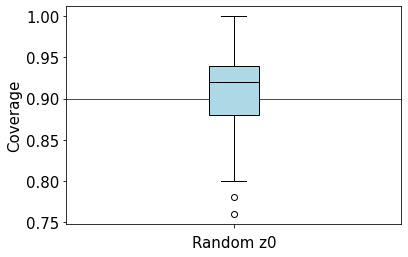

In [9]:
###
plt.boxplot(IR, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))
plt.yticks( fontsize=10)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=1)
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.yticks( fontsize=15)


In [10]:

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]


def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, N=1000):
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, var_x, dimension_x)

        # Compute T_1 and T_2 using the generated functions
        T_1 = function_2(X, Z)
        #T_2 = function_2(X, Z)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = flatten_features(D_train)
    # Extracting T_1 for D_train and D_cali
    Y_train = D_train['T_1'].values
    #构建神经网络模型
    model_nn = Sequential([
        InputLayer(input_shape=(X_train.shape[1],)),   
        Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # 使用LeakyReLU和L2正则化
        Dropout(0.3),
        Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
        Dense(1)                       # 输出层
    ])

    # 编译模型
    model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # 在 D_train 上训练模型
    history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
    
    
    score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, var_x, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_2(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [11]:


np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
m_0 = 50
IR_compare = []
ratio = []
Pay = []
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

for i in range(200):
    result = conformal_predict(alpha=0.1, m=m_0,  Z_new=Z_new, N = 10000)
    IR_compare.append(result[2])
    ratio.append(result[1])
    Pay.append(result[0])


/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

In [12]:
IR_compare

[0.0,
 0.0,
 0.048272670824506925,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4619452869087999,
 6.254068942144713,
 2.613290362233739,
 0.0,
 0.0,
 0.0,
 4.9937534620693995,
 6.5005295323929495,
 0.0,
 0.0,
 0.9994114297220378,
 0.0,
 0.05165829720760762,
 4.34553972438154,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8281177686396308,
 0.0,
 0.4440629857066831,
 0.28917245634084043,
 1.1631479731054153,
 0.0,
 0.0,
 2.484567109066596,
 0.13881510939531516,
 4.30806510686943,
 0.0,
 0.0,
 0.0,
 0.0,
 11.193039214437874,
 -0.46025755289249304,
 1.4527434623648041,
 0.0,
 0.0,
 0.0,
 12.218788107239785,
 6.0252422221887265,
 3.8369356825101963,
 0.0,
 -2.563195502253528,
 0.0,
 0.0,
 0.0,
 -0.5562465163469312,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9270366632873248,
 0.36479818261914954,
 -2.4407323889989136,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.332137188581155,
 0.0,
 0.0,
 0.7458936730746313,
 -0.012779986335514693,
 0.0,
 -0.017591993806060024,
 -1.226768564519217,
 1.0274579459486475,
 1.20291131

(-0.75, 1.0)

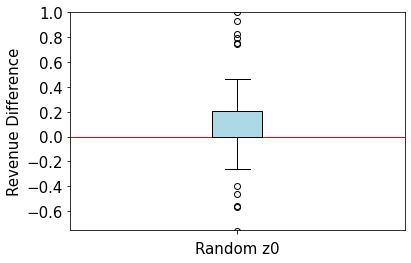

In [13]:
###
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Revenue Difference', fontsize=15)
plt.boxplot(IR_compare, patch_artist=True, boxprops=dict(facecolor='lightblue'),  # Box color set to blue
            medianprops=dict(color="black"))
plt.yticks( fontsize=15)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0, color='red', linestyle='-', label='', linewidth=1)
plt.ylim(-0.75,1)

In [13]:
var = 8
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, var, dimension_x)
        # Compute T_1  using the generated functions
        T_1_new = function_2(X_new, Z_new)
        
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [14]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]


np.random.seed(0)
random.seed(0)
tf.random.set_seed(1)
# 设置 N 的不同值
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
num_runs = 1000

# 初始化用于存储结果的字典
results = {"payment": [], "sb_value": [], "max_welfare": []}

# 对于每个 N 值，运行函数 200 次并计算平均值
for N in N_values:
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, var, dimension_x)

        # Compute T_1 and T_2 using the generated functions
        T_1 = function_2(X, Z)
        #T_2 = function_2(X, Z)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = flatten_features(D_train)
    # Extracting T_1 for D_train and D_cali
    Y_train = D_train['T_1'].values
    #构建神经网络模型
    model_nn = Sequential([
        InputLayer(input_shape=(X_train.shape[1],)),   
        Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # 使用LeakyReLU和L2正则化
        Dropout(0.3),
        Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
        Dense(1)                          # 输出层
    ])

    # 编译模型
    model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # 在 D_train 上训练模型
    history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
    score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())
    
    payments, sb_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(0.1, 50, Z_new)
        payments.append(payment)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [16]:
results

{'payment': [9.259600318829031,
  9.120179070509524,
  9.43927166583349,
  9.95688489794366,
  9.967048813390418,
  9.933572154646331,
  10.262721006666231],
 'sb_value': [9.258908756300112,
  8.861533286584207,
  9.130233694577848,
  9.286801809880119,
  9.1333418652814,
  9.0464350234246,
  9.161528826467599],
 'max_welfare': [14.937484521932829,
  13.878619566050851,
  14.486882971470692,
  14.86642662034301,
  14.395323131326979,
  14.676496921855586,
  14.18317628267819]}

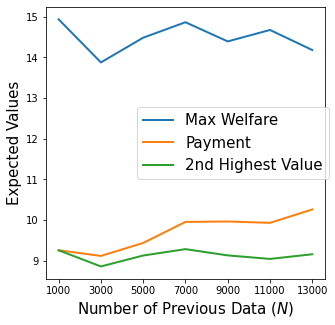

In [17]:
###

plt.figure(figsize=(5,5))  # 修改此处以创建正方形的图形
plt.plot(N_values[0:7], results["max_welfare"][0:7], label="Max Welfare", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results["payment"][0:7], label="Payment", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results["sb_value"][0:7], label="2nd Highest Value", linewidth=2)  # 加粗线条


# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=15)
plt.ylabel("Expected Values", fontsize=15)

# 设置图例和字体大小
plt.legend(fontsize=15, bbox_to_anchor=(0.3, 0.5), loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
#plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values[0:7], labels=[str(N) for N in N_values[0:7]], fontsize=30)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

In [8]:

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var_x = 8
data_points = []
N = 20000
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]

    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)

    # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
    X = np.random.normal(mean_x, var_x, dimension_x)

    # Compute T_1 and T_2 using the generated functions
    T_1 = function_2(X, Z)
    #T_2 = function_2(X, Z)

    # Append the data point (X, Z, T_1, T_2) to the list
    data_points.append([X, Z, T_1])
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

# Preparing data for regression
X_train = flatten_features(D_train)
# Extracting T_1 for D_train and D_cali
Y_train = D_train['T_1'].values
#构建神经网络模型
model_nn = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),   
    Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # 使用LeakyReLU和L2正则化
    Dropout(0.3),
    Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
    Dense(1)                       # 输出层
])

# 编译模型
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 在 D_train 上训练模型
history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)

score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
condCovProgram = CondConf(score_fn, phi_fn, {})
condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())

def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, var_x, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_2(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


In [9]:

# 设置 m 的不同值
m_values = list(range(50, 301, 50))

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 500

# 初始化用于存储结果的字典
results_m = {"payment": [], "y_value": [], "max_welfare": []}

# 对于每个 m 值，运行函数 100 次并计算平均值
for m in m_values:
    payments, y_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(0.1, m, Z_new)
        payments.append(payment)
        y_values.append(y_value)
        max_welfares.append(max_welfare)
    results_m["payment"].append(np.mean(payments))
    results_m["y_value"].append(np.mean(y_values))
    results_m["max_welfare"].append(np.mean(max_welfares))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
10/10 ━━━━━━━━━━━

In [10]:
results_m

{'payment': [10.700304630051637,
  13.246675794150645,
  15.429254995844907,
  17.256931955608,
  17.932133210044164,
  19.70848844131358],
 'y_value': [9.346362596911318,
  11.8939963478709,
  14.253566415994978,
  15.64158608877601,
  16.8563226509954,
  18.674921138225432],
 'max_welfare': [15.113063777143816,
  18.274275633961448,
  21.023984757418763,
  24.33984867125046,
  24.866056746143673,
  27.54903893355935]}

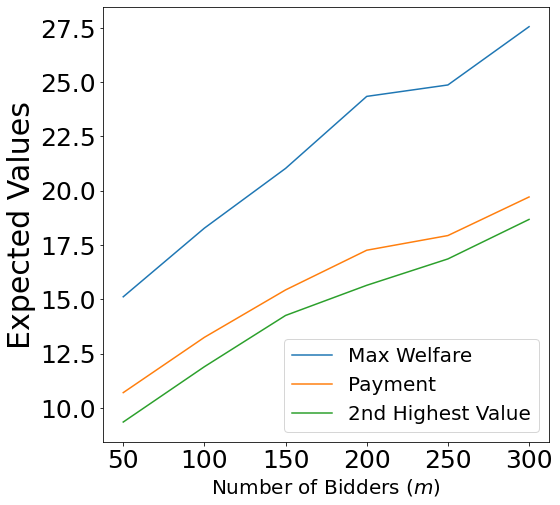

In [11]:
###
# 绘制结果图
plt.figure(figsize=(8, 8))
plt.plot(m_values, results_m["max_welfare"], label="Max Welfare")
plt.plot(m_values, results_m["payment"], label="Payment")
plt.plot(m_values, results_m["y_value"], label="2nd Highest Value")

plt.xlabel("Number of Bidders $(m)$", fontsize=20)
plt.ylabel("Expected Values", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小
plt.legend(fontsize=20, loc='lower right')
plt.show()